# Trabajo Práctico Nro. 1
## Machine Learning 2.

Alumnos:
  - Crenna, Giuliano.
  - Sancho Almenar, Marinano.
  - Pace, Bruno.

# **DESCRIPCIÓN**

En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo.

El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

# **OBJETIVO**

Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.

Los modelos a diseñar son:
- Modelo con capas densas.
- Modelo con capas convolucionales y densas.
- Modelo que incluya bloques residuales identidad:
  
- Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow


# Preparación del entorno

Importación de las librerias

In [14]:
import os
import zipfile
import random
import gdown
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Rescaling, Activation, RandomFlip, RandomTranslation, RandomContrast
from PIL import Image
from pathlib import Path

Configuración GPU

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

Carga del dataset

In [3]:
!pip install -q gdown

In [4]:
url = 'https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=59f8175d-8bbc-474a-9ae6-b3347b56c20f
To: /content/dataset.zip
100%|██████████| 363M/363M [00:07<00:00, 46.6MB/s]


'dataset.zip'

In [5]:
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [6]:
TRAIN_PATH = Path('data/seg_train/seg_train')
VAL_PATH = Path('data/seg_test/seg_test')
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 32

# Cargar dataset desde carpetas
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


# EDA

## Cantidad y nombres de clases

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Cantidad de imágenes por clase

In [11]:
from collections import Counter

label_counts = Counter()

# Recorremos el dataset una vez para contar etiquetas
for images, labels in train_ds:
    for label in labels:
        class_index = tf.argmax(label).numpy()
        label_counts[class_names[class_index]] += 1

# Convertir a listas para plotly
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Crear gráfico de barras
fig = px.bar(
    x=labels,
    y=counts,
    labels={'x': 'Clase', 'y': 'Cantidad de imágenes'},
    title='Cantidad de imágenes por clase en el dataset de entrenamiento',
    color=labels,
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig.show()

Se observa que el conjunto de entrenamiento se encuentra balanceado para todas las clases

## Visualización de imágenes

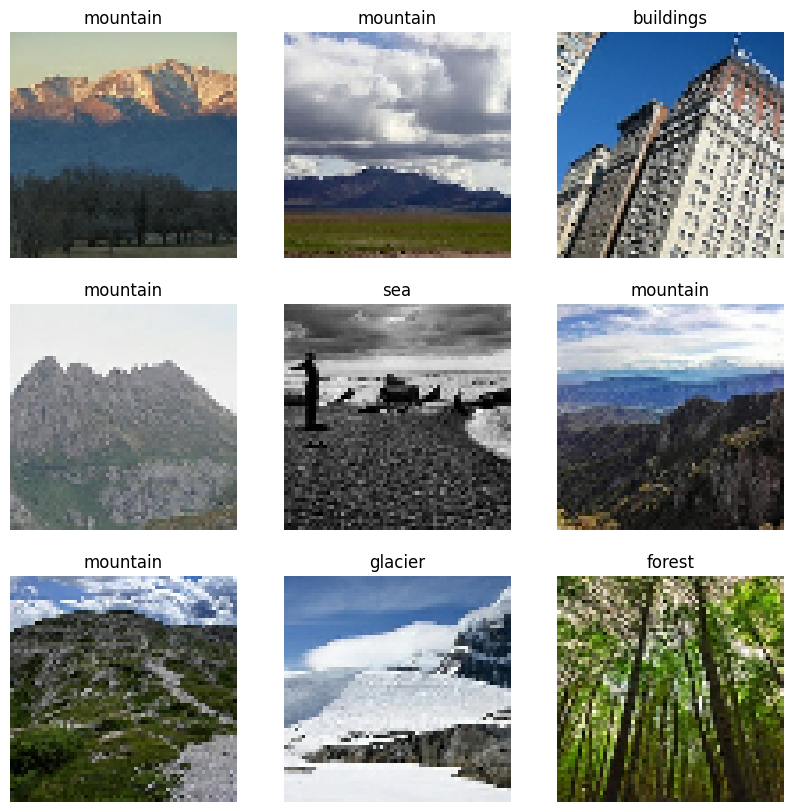

In [12]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")


# Modelos

In [23]:
def acc_loss_plot(history):
  # Plot the training history, accuracy and loss
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([0, 2])
  plt.legend(loc='upper right')


## Modelo sólo con capas densas



### Construcción

In [31]:
def build_dense_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    #x = RandomFlip("horizontal")(x)
    #x = RandomFlip("vertical")(x)
    #x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    #x = RandomContrast(0.2)(x)
    x = Flatten()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    x = Dense(output_labels, activation = 'softmax')(x)

    return tf.keras.Model(inputs=i, outputs=x)


In [32]:
print("Building model")
dense_model = build_dense_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

dense_model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

dense_model.summary()

Building model


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,585,798 (6.05 MB)

 Trainable params: 1,585,798 (6.05 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [33]:
# Entrena el modelo
dense_history = dense_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
   )

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.3224 - loss: 1.7632 - val_accuracy: 0.4263 - val_loss: 1.4135
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.4198 - loss: 1.4225 - val_accuracy: 0.4903 - val_loss: 1.3680
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4382 - loss: 1.4031 - val_accuracy: 0.4947 - val_loss: 1.3295
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4464 - loss: 1.3619 - val_accuracy: 0.5003 - val_loss: 1.2890
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.4717 - loss: 1.3190 - val_accuracy: 0.4987 - val_loss: 1.3097
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.4952 - loss: 1.2913 - val_accuracy: 0.4883 - val_loss: 1.3047
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4919 - loss: 1.2829 - val_accuracy: 0.4877 - val_loss: 1.3075
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5010 - loss: 1.2658 - 

### Métricas

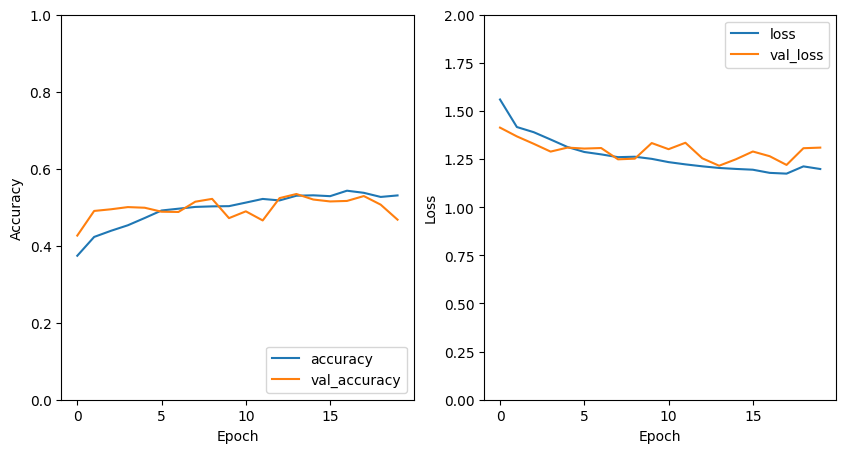

In [35]:
acc_loss_plot(dense_history)

### Predicción

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


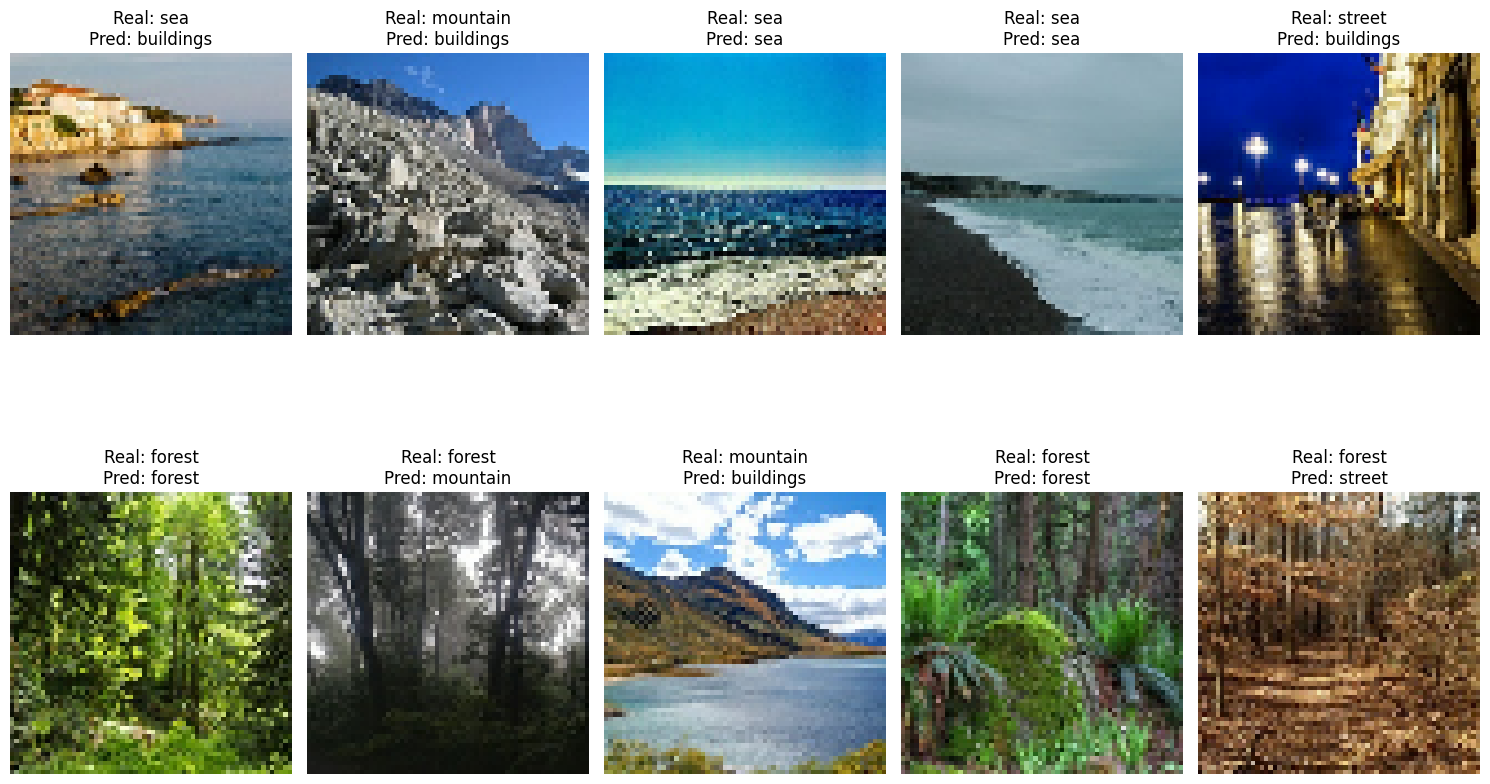

In [34]:
for images, labels in val_ds.take(1):
    # Hacer predicciones
    predictions = dense_model.predict(images)

    # Mostrar las primeras 10 imágenes del batch
    plt.figure(figsize=(15, 10))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_class = tf.argmax(labels[i]).numpy()
        pred_class = np.argmax(predictions[i])

        plt.title(f"Real: {class_names[true_class]}\nPred: {class_names[pred_class]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━

<Figure size 800x600 with 0 Axes>

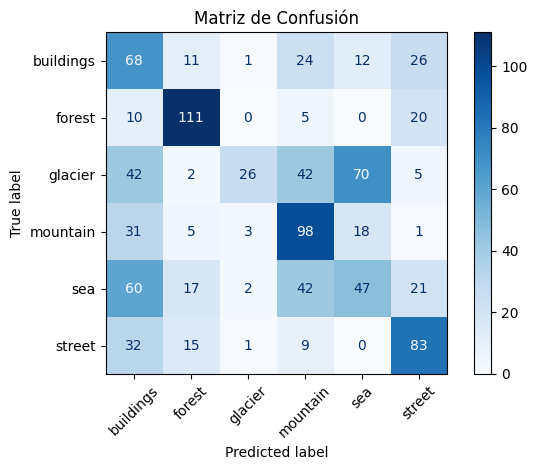

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Recolectar verdaderos y predichos
y_true = []
y_pred = []

for images, labels in val_ds.take(30):
    preds = dense_model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Mostrar
plt.figure(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()